# 🇸🇦 Saudi License Plate Recognition System (ALPR)
### A Multi-Stage AI Pipeline using YOLOv11

---

### 📝 Project Overview
This notebook implements an **Automatic License Plate Recognition (ALPR)** system tailored specifically for Saudi Arabian vehicle plates. Unlike traditional OCR-based approaches, this project utilizes a **Cascade Object Detection** strategy, treating individual characters as objects to ensure robustness against dust, shadows, and varying camera angles.

### ⚙️ The Engineering Pipeline
Our solution processes images in four distinct stages:

1.  **🎯 Plate Detection:**
    * **Model:** YOLOv11 (Trained on ~4,500 images)
    * **Task:** Locates the license plate on the vehicle frame.
2.  **🔠 Character Detection (The Reader):**
    * **Model:** YOLOv11-small (Trained on ~1,300 annotated plates)
    * **Task:** Detects individual English characters and numbers (`0-9`, `A-Z`) as distinct objects.
3.  **🧠 Logic & Post-Processing:**
    * **Geometric Filtering:** Filters out Arabic script and logos based on vertical position (Top 35% exclusion).
    * **Sorting:** Orders detected characters left-to-right based on X-coordinates.
    * **Mapping:** Programmatically maps English detections to their corresponding Arabic script (e.g., `A` → `ا`, `9` → `٩`).

---

### 🛠️ Tech Stack
* **Core AI:** Ultralytics YOLOv11
* **Computer Vision:** OpenCV & Supervision
* **Data Management:** Roboflow

---

## 📦 Step 1: Environment Setup & Data Acquisition

In this section, we set up the development environment and acquire the necessary training data.

### 📚 Libraries
We install four core libraries to power our pipeline:
* **`ultralytics`**: The framework for training and running YOLOv8/v11 models.
* **`roboflow`**: To programmatically download our datasets from the cloud.
* **`inference`**: For running optimized model predictions.
* **`supervision`**: A powerful utility for handling detection results and drawing professional annotations (bounding boxes & labels).

### 🗂️ Dual-Dataset Strategy
We are downloading **two distinct datasets** to train our "Cascade System":
1.  **🚗 Plate Dataset:** A large collection (~4,500 images) used to train the first model to *find* the license plate on the car.
2.  **🔠 Character Dataset:** A highly specific collection (~1,300 images) used to train the second model to *read* the individual letters and numbers inside the plate.

> **🔑 Important:** This notebook uses Google Colab's "Secrets" feature. Ensure you have added your `ROBOFLOW_API_KEY` to the Secrets manager (Key icon in the left sidebar) before running this cell.

In [ ]:
# install libraries
!pip install -q ultralytics roboflow inference supervision
# get the data from roboflow
from roboflow import Roboflow
from google.colab import userdata
api_key = userdata.get("ROBOFLOW_API_KEY")
# installing Plates dataset
rf = Roboflow(api_key=api_key)
project = rf.workspace('doing-things').project('saudi-licence-plates-p36fj')
version = project.version(1)
plate_dataset = version.download('yolov11')
# installing letters and numbers detector dataset
project = rf.workspace('doing-things').project('number-plates-detection-et8rf-zt4oi')
version = project.version(1)
letters_dataset = version.download('yolov11')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 63.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/


Extracting Dataset Version Zip to Saudi-Licence-Plates-1 in yolov11:: 100%|██████████| 9032/9032 [00:01<00:00, 5905.43it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Number-Plates-Detection--1 in yolov11:: 100%|██████████| 3592/3592 [00:00<00:00, 6421.68it/s]


## 🧠 Step 2: Training the Plate Detector (Model A)

Now that our data is ready, we begin training the **Plate Detection Model**. This model's sole responsibility is to locate the license plate on the vehicle, regardless of angle, lighting, or distance.

### 🔄 The Process
1.  **Fine-Tuning:** We use the `!yolo` command to fine-tune our model using the downloaded dataset.
    * `model='/content/plate_yolo_best.pt'`: We utilize **Transfer Learning** by starting with weights that have already learned basic features, rather than training from scratch.
    * `epochs=5`: We run a short training cycle (5 epochs) to quickly adapt the model to our specific data.
2.  **☁️ Deployment (MLOps):**
    * After training, we use `version.deploy()` to upload the trained weights back to the Roboflow cloud.
    * **Why do this?** This allows us to access the model via an API endpoint later in the code (using `get_model`), simulating a real-world production environment where models are hosted remotely.

In [ ]:
# train and load plates detector model
!yolo task=detect mode=train model='/content/plate_yolo_best.pt' data={plate_dataset.location}/data.yaml epochs=5 imgsz=640 batch=16
project = rf.workspace('doing-things').project('saudi-licence-plates-p36fj')
version = project.version(2)
version.deploy(model_type='yolov11', model_path='/content/runs/detect/train')

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Saudi-Licence-Plates-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/plate_yolo_best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

## 🔡 Step 3: Training the Character Recognizer (Model B)

This is the most precise step in the pipeline. While finding a license plate is relatively easy (it's a distinct rectangle), distinguishing between a letter `B` and a number `8` requires much higher accuracy. Therefore, we dedicate more training resources to this model.

### ⚙️ Training Configuration
We are training a **YOLOv11 Small (`s`)** model with specific hyperparameters tailored for character recognition:

* **`model=yolo11s.pt`**: We use the "Small" version of YOLOv11. It offers a perfect balance—lightweight enough to run quickly, but complex enough to understand subtle font differences.
* **`epochs=50`**: Unlike the plate detector (5 epochs), we train this model for **50 epochs**. Character recognition requires extended training to minimize classification errors.
* **`batch=32`**: A higher batch size helps stabilize the gradient descent during training, leading to a more generalized model.

### ☁️ Deployment
Once training completes, we deploy this model to Roboflow as `Version 1` of our "Number Plates Detection" project. This effectively creates our **"Expert Reader"** API endpoint.

In [ ]:
# train and load letters detector model
!yolo task=detect mode=train model=yolo11s.pt data={letters_dataset.location}/data.yaml epochs=50 imgsz=640 batch=32
project = rf.workspace('doing-things').project('number-plates-detection-et8rf-zt4oi')
version = project.version(1)
version.deploy(model_type='yolov11', model_path='/content/runs/detect/train2')

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Number-Plates-Detection--1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

In [ ]:
import shutil
from google.colab import files
# download the files locally
shutil.make_archive('/content/runs_backup', 'zip', '/content/runs')
files.download('/content/runs_backup.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🚀 Step 4: The Final Inference Pipeline

This is the core execution block. Here, we combine our trained models (`best.pt` from the Plate Detector and `best.pt` from the Character Detector) into a unified **Cascade System**.

### 🧩 System Logic
1.  **Model Loading:** We load the best weights generated from the training sessions in Steps 2 and 3.
2.  **Cascade Execution:**
    * **Pass 1 (Plate Detection):** The first model scans the full image to find the license plate and returns the bounding box coordinates.
    * **Cropping:** We extract the specific region of interest (ROI) to remove the car and background.
    * **Pass 2 (Character Recognition):** The second model scans the *cropped* plate to identify individual letters and numbers.
3.  **🧠 Advanced Post-Processing:**
    * **Spatial Sorting:** YOLO detections come in random order. We programmatically sort them from **Left-to-Right** based on their X-coordinates to form a coherent string.
    * **Noise Filtration:** We use **Regular Expressions (Regex)** to dynamically remove stray numbers that might appear inside the letter blocks (a common issue with specific fonts).
    * **Localization:** Finally, we map the English characters to their official Saudi Arabic counterparts (e.g., `S` $\rightarrow$ `س`) to present the data in the local format.

### 🖼️ Visualization
The code below uses `cv2_imshow` to display the intermediate steps (Original Image $\rightarrow$ Cropped Plate) and prints the final recognized ID in both languages.


image 1/1 /content/car_plate5.jpg: 640x416 1 LP, 72.6ms
Speed: 2.4ms preprocess, 72.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 416)
Original Image


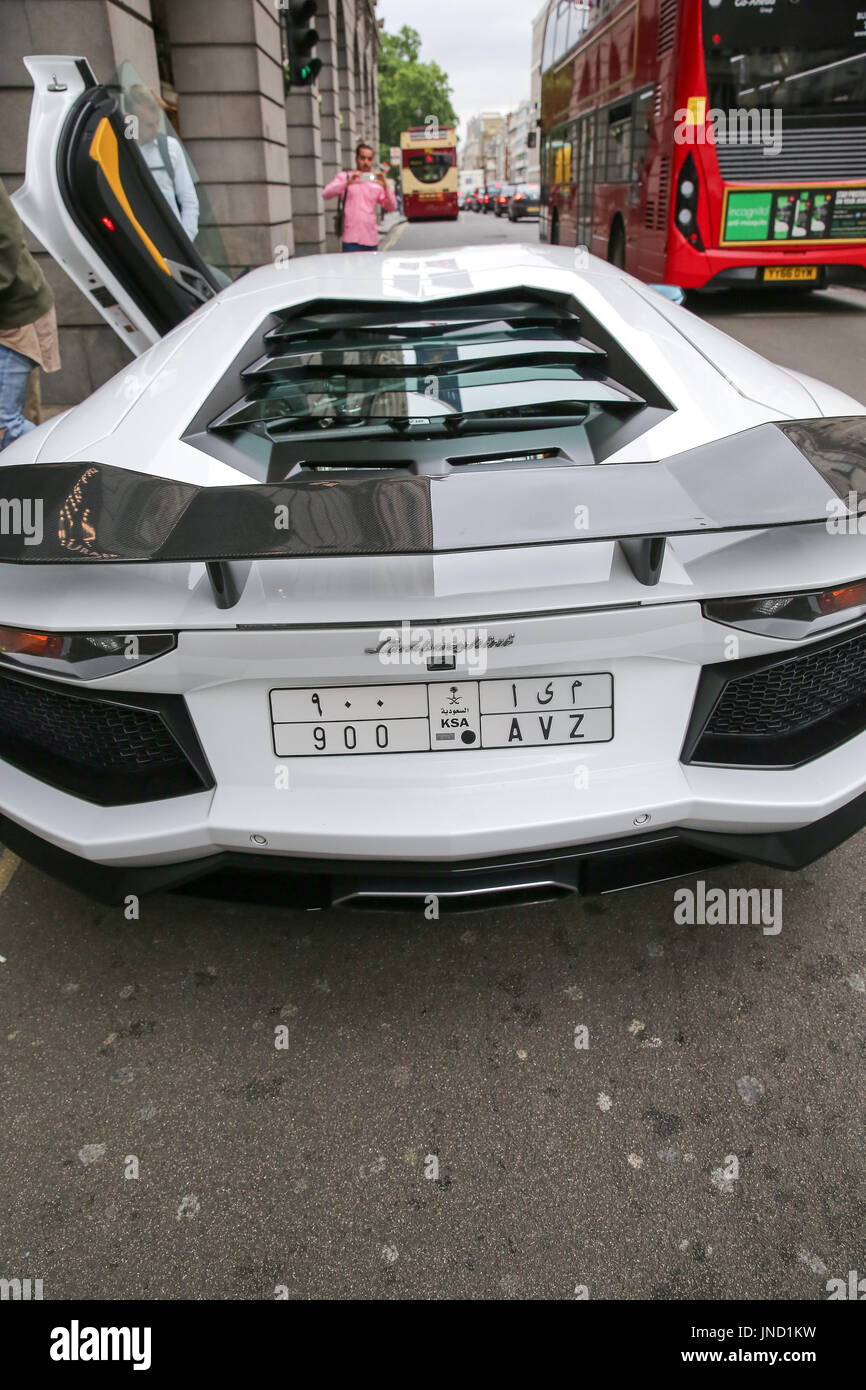

Plate Image


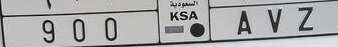


0: 96x640 2 0s, 1 7, 1 9, 1 A, 2 Platess, 1 V, 1 Z, 92.3ms
Speed: 0.9ms preprocess, 92.3ms inference, 7.2ms postprocess per image at shape (1, 3, 96, 640)
Plate Charachters Arabic:  م ٧ ى ا   ٠ ٠ ٩
Plate Charachters English:  9 0 0   A V 7 Z


In [ ]:
import numpy as np
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import re

# Load plate YOLO detector
plate_yolo = YOLO('/content/runs/detect/train/weights/best.pt')
# Load charachters YOLO detector
char_yolo = YOLO('/content/runs/detect/train2/weights/best.pt')

def get_plate(img_path):
  if img_path is None:
     return None
  plate = plate_yolo(img_path)
  if not plate or len(plate[0].boxes) == 0:
    print("No licence plate found")
    return

  # get plate box
  box = plate[0].boxes[0]
  x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
  return x1, y1, x2, y2

def crop_image(img_path, box):
  if img_path is None: return None
  img = cv2.imread(img_path)
  print("Original Image")
  cv2_imshow(img)
  x1, y1, x2, y2 = box
  plate_img = img[y1:y2, x1:x2]
  print("Plate Image")
  cv2_imshow(plate_img)
  return plate_img
def get_arabic_chars(plate_chars_en):
  english_to_arabic_map = {
    # Letters
    'A': 'ا',
    'B': 'ب',
    'J': 'ح',
    'D': 'د',
    'R': 'ر',
    'S': 'س',
    'X': 'ص',
    'T': 'ط',
    'E': 'ع',
    'G': 'ق',
    'K': 'ك',
    'L': 'ل',
    'Z': 'م',
    'N': 'ن',
    'H': 'ه',
    'U': 'و',
    'V': 'ى',
    # Numbers
    '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤',
    '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩'
  }
  plate_chars_ar = []
  for char in plate_chars_en:
    if char in english_to_arabic_map:
      plate_chars_ar.append(english_to_arabic_map[char])
    else:
      plate_chars_ar.append(char)
  return "".join(plate_chars_ar)


def get_charachters(img):
  if img is None: return None
  result = char_yolo(img)
  if not result or len(result[0].boxes) == 0:
    print("No charachters found")
    return
  detections = []
  for box in result[0].boxes:
    # get coordinates
    cx1, cy1, cx2, cy2 = box.xyxy[0].cpu().numpy().astype(int)
    # get class ID
    cls_id = int(box.cls[0])
    # get class name, convert ID to letter
    cls_name = char_yolo.names[cls_id]
    # get confidence
    conf = float(box.conf[0])

    # calculate center of charachter, for sorting
    center_x = (cx1 + cx2) / 2
    center_y = (cy1 + cy2) / 2
    # save the result in list
    detections.append((center_x, cls_name, conf))

  # sort the list from left to right
  detections.sort(key=lambda x: x[0])

  plate_chars = ' '.join([d[1] for d in detections])

  # process plate_char
  if "Plates" in plate_chars:
    plate_chars = plate_chars.replace("Plates", "")
  if "backgournd" in plate_chars:
    plate_chars = plate_chars.replace("backgournd", "")
  # remove any number that is sandwitched between letters
  plate_chars_en = re.sub(r'(?<=[a-zA-Z])\d+', '', plate_chars)
  plate_chars_ar = get_arabic_chars(plate_chars_en)
  print("Plate Charachters Arabic: ", plate_chars_ar[::-1])
  print("Plate Charachters English: ", plate_chars_en)

def process_img(img_path):
  get_charachters(crop_image(img_path,get_plate(img_path)))

process_img('/content/car_plate5.jpg')
